In [2]:
import bezier
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.spatial import ConvexHull

# Translation points to Bezier representation

In [3]:
nodes = np.asfortranarray([
        [1, 1.5, 2.5, 3],
        [1, 1.5 , 0.5, 1],
    ])
curve = bezier.Curve(nodes, degree=3)

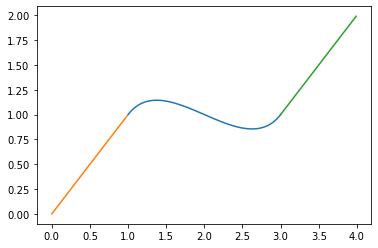

In [4]:
curve.plot(100)
plt.plot([0.01 * i for i in range(100)], [0.01 * i for i in range(100)])
plt.plot([0.01 * i + 3 for i in range(100)], [0.01 * i + 1 for i in range(100)])

In [5]:
curve.evaluate(0.5).T[0]

array([2., 1.])

In [6]:
def get_vector(segment):
    return np.array(segment[1] - segment[0])

In [7]:
get_vector(np.array([[1, 1], [2, 3]]))

array([1, 2])

In [8]:
def get_track(points):
    
    segments = []
    curves = []
    for i in range(len(points) // 2):
        segments.append([points[2*i], points[2*i+1]])
    
    segments = np.array(segments)
    for i in range(len(segments)):
        s1 = segments[i]
        s2 = segments[(i + 1) % len(segments)]
        
        v1 = 0.5 * get_vector(s1)
        v2 = 0.5 * get_vector(s2[::-1])
        
        nodes = np.vstack((s1[1], s1[1] + v1, s2[0] + v2, s2[0])).T
        
        curves.append(bezier.Curve(nodes, degree=3))
    
    return segments, curves

In [9]:
def draw_track(segments, curves):
    for s in segments:
        x_values = [s[0][0], s[1][0]]
        y_values = [s[0][1], s[1][1]]
        plt.plot(x_values, y_values)

    i = 0
    for c in curves:
        xs = [c.evaluate(x).T[0][0] for x in np.linspace(0, 1, 100)]
        ys = [c.evaluate(x).T[0][1] for x in np.linspace(0, 1, 100)]

        plt.plot(xs, ys)

        i += 1


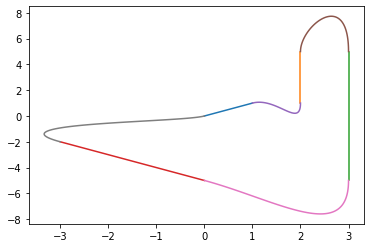

In [10]:
segments, curves = get_track([[0, 0], [1, 1], [2, 1], [2, 5], [3, 5], [3, -5], [0, -5], [-3, -2]])
draw_track(segments, curves)

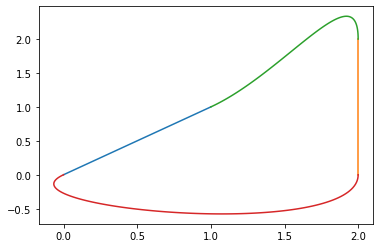

In [11]:
segments, curves = get_track([[0, 0], [1, 1], [2, 2], [2, 0]])
draw_track(segments, curves)

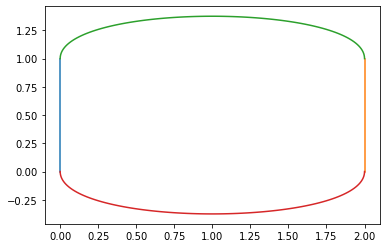

In [12]:
segments, curves = get_track([[0, 0], [0, 1], [2, 1], [2, 0]])
draw_track(segments, curves)

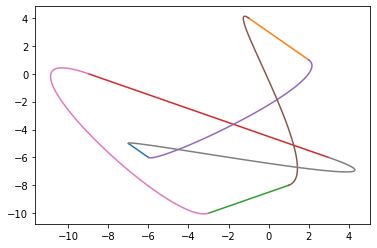

In [13]:
segments, curves = get_track([[random.randrange(-10, 10), random.randrange(-10, 10)] for _ in range(8)])
draw_track(segments, curves)

[[ -4  -5]
 [ -2   8]
 [ -2  -3]
 [ -8   9]
 [ -2  -3]
 [  8  -2]
 [  6   2]
 [ -6  -8]
 [  1  -6]
 [  4  -2]
 [  8  -5]
 [ -3  -4]
 [  3  -1]
 [-10   6]
 [-10 -10]
 [ -8  -7]
 [ -1   9]
 [  9   7]
 [  7   6]]

[[-10   6]
 [-10 -10]
 [  8  -5]
 [  9   7]
 [ -1   9]
 [ -8   9]]


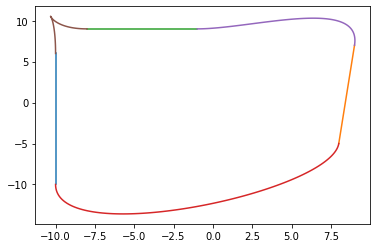

In [14]:
points = np.array([[random.randrange(-10, 10), random.randrange(-10, 10)] for _ in range(19)])

print(points)
print()
print(points[ConvexHull(points).vertices])
segments, curves = get_track(points[ConvexHull(points).vertices])
draw_track(segments, curves)

# Translation of Bezier representation to Torcs representation

In [15]:
def translate_curve(curve, K = 50):
    vecs = []
    vals = []
    anses = []
    for i in np.linspace(0,1,K + 1):
        # print(i)
        t = curve.evaluate_hodograph(i)
        tp = np.array([t[1], -t[0]])
        vecs += [tp]
        v = curve.evaluate(i)
        vals += [v]
        # print(v)

    for i in range(K):
        start_pos = vals[i]
        end_pos = vals[i+1]
        start_vec = vecs[i]
        end_vec = vecs[i+1]

        m = np.concatenate([start_vec, end_vec], axis=1)
        ans = np.linalg.inv(m) @ (end_pos - start_pos)

        d = np.linalg.det(m)

        p = start_pos + ans[0,0] * start_vec
        
        v1 = p - start_pos
        v2 = p - end_pos

        r1 = np.linalg.norm(v1)
        r2 = np.linalg.norm(v2)
        
        hmm = max(-1, min(1, v1.T.dot(v2)[0][0] / (r1 * r2)))
        #print(hmm)
        arc =  np.degrees(np.arccos(hmm))
        #print(arc)
        
        if hmm == 1:
            anses += [("Str", np.linalg.norm(start_pos - end_pos))]
        else:
            anses += [("Arc", r1, r2, arc, d>0)]
        
    # for ans in anses:
    #     print(ans)
    return anses

In [16]:
def fill_section_cur(id, left, deg, radius, end_radius):
    w = "rgt" if not left else "lft"
    return f"""
<section name="curve {id}">
    <attstr name="type" val="{w}" />
    <attnum name="arc" unit="deg" val="{deg}" />
    <attnum name="radius" unit="m" val="{radius}" />
    <attnum name="end radius" unit="m" val="{end_radius}" />
    <attnum name="z start" unit="m" val="0.0" />
    <attnum name="z end" unit="m" val="0.0" />
    <attstr name="surface" val="asphalt2-lines" />
    <!--Left part of segment-->
    <section name="Left Side">
        <attnum name="start width" unit="m" val="4.0" />
        <attnum name="end width" unit="m" val="4.0" />
        <attstr name="surface" val="grass" />
    </section>
    <section name="Left Border">
        <attnum name="width" unit="m" val="0.5" />
        <attnum name="height" unit="m" val="0.05" />
        <attstr name="surface" val="curb-5cm-r" />
        <attstr name="style" val="plan" />
    </section>
    <section name="Left Barrier">
        <attnum name="width" unit="m" val="0.1" />
        <attnum name="height" unit="m" val="1.0" />
        <attstr name="surface" val="barrier" />
        <attstr name="style" val="curb" />
    </section>
    <!--End of left part-->
    <!--Right part of segment-->
    <section name="Right Side">
        <attnum name="start width" unit="m" val="4.0" />
        <attnum name="end width" unit="m" val="4.0" />
        <attstr name="surface" val="grass" />
    </section>
    <section name="Right Border">
        <attnum name="width" unit="m" val="0.5" />
        <attnum name="height" unit="m" val="0.05" />
        <attstr name="surface" val="curb-5cm-r" />
        <attstr name="style" val="plan" />
    </section>
    <section name="Right Barrier">
        <attnum name="width" unit="m" val="0.1" />
        <attnum name="height" unit="m" val="1.0" />
        <attstr name="surface" val="barrier" />
        <attstr name="style" val="curb" />
    </section>
    <!--End of right part-->
    </section>
      """

In [17]:
def fill_section_str(id, length):
    return f"""
<section name="straight {id}">
    <attstr name="type" val="str" />
    <attnum name="lg" unit="m" val="{length}" />
    <attnum name="z start" unit="m" val="0.0" />
    <attnum name="z end" unit="m" val="0.0" />
    <attstr name="surface" val="asphalt2-lines" />
    <!--Left part of segment-->
    <section name="Left Side">
        <attnum name="start width" unit="m" val="4.0" />
        <attnum name="end width" unit="m" val="4.0" />
        <attstr name="surface" val="grass" />
    </section>
    <section name="Left Border">
        <attnum name="width" unit="m" val="0.5" />
        <attnum name="height" unit="m" val="0.05" />
        <attstr name="surface" val="curb-5cm-r" />
        <attstr name="style" val="plan" />
    </section>
    <section name="Left Barrier">
        <attnum name="width" unit="m" val="0.1" />
        <attnum name="height" unit="m" val="1.0" />
        <attstr name="surface" val="barrier" />
        <attstr name="style" val="curb" />
    </section>
    <!--End of left part-->
    <!--Right part of segment-->
    <section name="Right Side">
        <attnum name="start width" unit="m" val="4.0" />
        <attnum name="end width" unit="m" val="4.0" />
        <attstr name="surface" val="grass" />
    </section>
    <section name="Right Border">
        <attnum name="width" unit="m" val="0.5" />
        <attnum name="height" unit="m" val="0.05" />
        <attstr name="surface" val="curb-5cm-r" />
        <attstr name="style" val="plan" />
    </section>
    <section name="Right Barrier">
        <attnum name="width" unit="m" val="0.1" />
        <attnum name="height" unit="m" val="1.0" />
        <attstr name="surface" val="barrier" />
        <attstr name="style" val="curb" />
    </section>
    <!--End of right part-->
    </section>
      """

In [18]:
def get_len(s):
    return np.sqrt((s[1][0] - s[0][0]) ** 2 + (s[1][1] - s[0][1]) ** 2)

In [19]:
def to_xml(segments, curves):
    res  = ""
    id = 0
    for i in range(len(segments)):
        res += fill_section_str(id, get_len(segments[i]) * 100)
        id += 1
        anses = translate_curve(curves[i], 100)

        for j in range(len(anses)):
            ans = anses[j]
            if ans[0] == "Arc":
                r1, r2, arc, left = ans[1:]
                res += fill_section_cur(id, left, arc, 100*r1, 100*r2)
                id += 1
            else:
                length, = ans[1:]
                res += fill_section_str(id, length * 100)
                id += 1

    return res

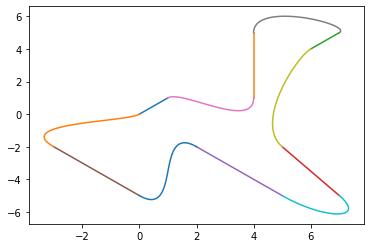

In [37]:
segments, curves = get_track(np.array([[0, 0], [1, 1], [4, 1], [4, 5], [7, 5], [6, 4], [5, -2], [7, -5], [5, -5], [2, -2], [0, -5], [-3, -2]]))
draw_track(segments, curves)
res = to_xml(segments, curves)

In [38]:
def save_to_file(s):
    with open('output.txt', "w") as f:
        f.write(s)

In [40]:
save_to_file(res)